In [19]:
import sys
import importlib.util


from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/Projects/GitHub/ClusterNetflix"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

config_path = f"{PROJECT_ROOT}/config.py"
spec = importlib.util.spec_from_file_location("config", config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
file_path = f"{config.DATA_PATH}/netflix_incomplete.txt"
df = pd.read_csv(file_path, sep=' ', header=None)
df = df.replace(0, np.nan)
n, d = df.shape
df.columns = [f"c_{i}" for i in range(d)]

df_copy = df.copy()

In [23]:
# Temporarily impute using mode
imputer = SimpleImputer(strategy='most_frequent')
X_temp = imputer.fit_transform(df)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_temp)


In [24]:
X_scaled.shape

(1200, 1200)

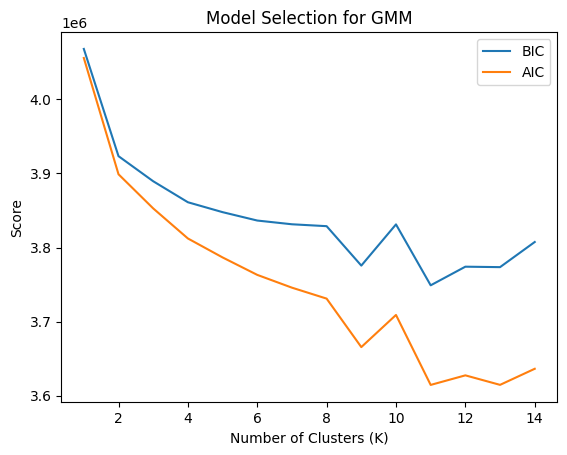

In [25]:
ks = range(1, 15)
bics = []
aics = []

for k in ks:
    gmm = GaussianMixture(n_components=k, n_init=10, covariance_type='diag', random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

# Plot to choose optimal K
plt.plot(ks, bics, label='BIC')
plt.plot(ks, aics, label='AIC')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score')
plt.title('Model Selection for GMM')
plt.legend()
plt.show()


In [26]:
# fit GMM
k_chosen = 11
gmm = GaussianMixture(n_components=k_chosen, n_init=10, covariance_type="diag", random_state=42)
cluster_labels = gmm.fit_predict(X_scaled)

df_copy['cluster'] = cluster_labels

In [35]:
# Cluster-based mean imputation
for feature in df_copy.columns[:-1]:
    for cluster_id in df_copy["cluster"].unique():
        cluster_mean = df_copy.loc[
            (df_copy[feature].notnull()) & (df_copy["cluster"] == cluster_id), feature
        ].mean()

        if pd.notna(cluster_mean):
            fill_value = int(round(cluster_mean))
        else:
            fallback_mean = df_copy[feature].mean()
            fill_value = int(round(fallback_mean))

        mask = (df_copy[feature].isnull()) & (df_copy["cluster"] == cluster_id)
        df_copy.loc[mask, feature] = int(round(fill_value))


In [36]:
file_path = f"{config.DATA_PATH}/netflix_complete.txt"
df_true = pd.read_csv(file_path, sep=' ', header=None)


In [ ]:
df

In [37]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import numpy as np

true_ratings, predicted_ratings = df_true.values, df_copy.iloc[:,:-1].values
rmse = root_mean_squared_error(true_ratings, predicted_ratings)
mae = mean_absolute_error(true_ratings, predicted_ratings)
r2 = r2_score(true_ratings, predicted_ratings)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.4925
MAE : 0.1746
R² Score: 0.7085


In [38]:
# Mean Predictor
df_mean = df.fillna(df.mean())
true_ratings_baseline, predicted_ratings_baseline = \
    df_true.values, df_mean.values
rmse_b = root_mean_squared_error(true_ratings_baseline, predicted_ratings_baseline)
mae_b = mean_absolute_error(true_ratings_baseline, predicted_ratings_baseline)
r2_b = r2_score(true_ratings_baseline, predicted_ratings_baseline)

print(f"RMSE: {rmse_b:.4f}")
print(f"MAE : {mae_b:.4f}")
print(f"R² Score: {r2_b:.4f}")

RMSE: 0.4720
MAE : 0.1834
R² Score: 0.7288


In [39]:
table = {
    "Model": ["RMSE", "MAE", "R² Score"],
    "Cluster_impt": [rmse, mae, r2],
    "Mean Baseline": [rmse_b, mae_b, r2_b]
}

pd.DataFrame(table)

,Model,Cluster_impt,Mean Baseline
0,RMSE,0.492516,0.472040
1,MAE,0.174596,0.183408
2,R² Score,0.708469,0.728823
